# Demonstration of rtpipe analysis with FRB 121102

## A walkthrough for data preparation, finding transient, analyzing, visualization

This notebook demonstrates the Python library [rtpipe](https://github.com/caseyjlaw/rtpipe), which was used to make the first interferometric detection of a a Fast Radio Burst (Chatterjee et al 2017, "The direct localization of a fast radio burst and its host", http://dx.doi.org/10.1038/nature20797). 

Prerequisites to run this analysis:
1. Download data from Dataverse at https://doi.org/10.7910/DVN/TLDKXG and
2. Install [rtpipe](https://github.com/caseyjlaw/rtpipe) (uses anaconda and pip).

The original analysis was run in quasi-real-time on a cluster at the [Very Large Array](https://science.nrao.edu/facilities/vla) using [`realfast`](http://realfast.io). This demonstration is tuned to run on a laptop, find one burst from FRB 121102, and perform a rough analysis. For a more exact reproduction of the results in the publication, see the other notebooks in https://github.com/caseyjlaw/FRB121102. 

This analysis can be used to make visualizations, such as those at https://youtu.be/i3x0sBCQ_c8 or the sound files at http://dx.doi.org/10.7910/DVN/QSWJE6.

In [1]:
%matplotlib inline

## Import rtpipe and scientific python libraries

In [2]:
from __future__ import print_function
import pylab as pl
import numpy as np
import rtpipe
import rtlib_cython as rtlib
from scipy.io import wavfile

2017-01-02 08:00:01,810 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)



In [3]:
# move to directory with sdmfile and gainfile
sdmfile = '16A-459_TEST_1hr.57623.72670021991.cut'
gainfile = '16A-459_TEST_1hr.57623.72670021991.GN'

# a segment defines a piece of data in time. some tuning required for other FRB 121102 data files.
segment = 0 

In [4]:
# useful function for data visualization in notebook
def correctdata(st, data, u, v, w, corr='ph,dm', lm = None):
    data2 = data.copy()
    
    if 'ph' in corr:
        if lm:
            l1, m1 = lm
            rtlib.phaseshift_threaded(data2, st, l1, m1, u, v)
        else:
            print('No phase center provided')

    if 'dm' in corr:
        rtlib.dedisperse_par(data2, st['freq'], st['inttime'], st['dmarr'][0], [0, st['nbl']])
    
    return data2

## Summarize visibility cut-out file

To reduce the data volume, we have cut out small time windows to create the visibility data files. Only one scan contains valid data, so we quickly check for that scan here.

In [5]:
sdm = rtpipe.parsesdm.getsdm(sdmfile)

for scan in sdm.scans():
    try:
        print('Scan {0} binary data file: {1}'.format(scan.idx, scan.bdf.fname))
        bdfscan = int(scan.idx)
    except IOError:
        pass

Scan 6 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-459_TEST_1hr.57623.72670021991.cut/ASDMBinary/uid____evla_bdf_1471974264507


## Search for FRB

`rtpipe` begins by defining a dictionary with metadata from the observation, preferences for the search pipeline, and parameters derived from the joint consideration of both. The command below is tuned to find the known FRB with modest computational expense.

In [6]:
st = rtpipe.RT.set_pipeline(sdmfile, bdfscan, dmarr=[560.], dtarr=[1], flaglist=[('badap', 3., 0.2)], 
                                uvoversample=1.5, gainfile=gainfile, flagantsol=True, 
                                timesub='mean', npix_max=1024, logfile=False, savecands=False,
                               savenoise=False)

2017-01-02 08:00:02,627 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2017-01-02 08:00:02,628 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2017-01-02 08:00:02,629 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-459_TEST_1hr.57623.72670021991.GN
2017-01-02 08:00:02,630 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [560.0]
2017-01-02 08:00:02,631 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2017-01-02 08:00:02,632 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 1024
2017-01-02 08:00:02,633 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2017-01-02 08:00:02,634 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2017-01-02 08:00:02,635 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2017-01-02 08:00:02,636 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2017-01-02 08:00:02,636 - rtpipe.parses

In [7]:
rtpipe.RT.pipeline(st, segment)

2017-01-02 08:00:03,172 - rtpipe - INFO - Starting search of /lustre/aoc/projects/16A-459/fastimaging/16A-459_TEST_1hr.57623.72670021991.cut, scan 6, segments [0]
2017-01-02 08:00:05,184 - rtpipe.parsesdm - INFO - Reading scan 6, segment 0/0, times 17:51:21.920 to 17:51:25.920
2017-01-02 08:00:05,257 - rtpipe.parsesdm - INFO - Reading 800 ints starting at int 0
2017-01-02 08:00:12,029 - rtpipe.parsesdm - INFO - Found online flags for 144 antenna/time ranges.
2017-01-02 08:00:12,034 - rtpipe.parsesdm - INFO - Applied online flags to 0 ints.
2017-01-02 08:00:14,132 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14]
2017-01-02 08:00:14,207 - rtpipe.parsesdm - INFO - Calculating uvw at 2016/08/23/17:51:23.920 for scan 6 of source FRB121102-off
2017-01-02 08:00:14,302 - rtpipe.parsecal - INFO - Read telcalfile 16A-459_TEST_1hr.57623.72670021991.GN
2017-01-02 08:00:14,326 - rtpipe.parsecal - INFO - Applying gain solution for chans from 0-31
2017

## Hooray!

The previous command should find the first burst from FRB 121102 with SNR=29.1. This data was recorded on 23 August 2016 and the burst was found 5 hours later by [`realfast`](http://realfast.io)

## Next, get calibrated data to play (dedisperse, image)

We can simplify this by phasing data up at the (now known) location of FRB121102.

In [8]:
data = rtpipe.RT.pipeline_reproduce(st, candloc=[segment,0,0,0,0], product='data')

2017-01-02 08:01:21,962 - rtpipe.parsesdm - INFO - Reading scan 6, segment 0/0, times 17:51:21.920 to 17:51:25.920
2017-01-02 08:01:22,036 - rtpipe.parsesdm - INFO - Reading 800 ints starting at int 0
2017-01-02 08:01:29,425 - rtpipe.parsesdm - INFO - Found online flags for 144 antenna/time ranges.
2017-01-02 08:01:29,430 - rtpipe.parsesdm - INFO - Applied online flags to 0 ints.
2017-01-02 08:01:31,812 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14]
2017-01-02 08:01:31,889 - rtpipe.parsesdm - INFO - Calculating uvw at 2016/08/23/17:51:23.920 for scan 6 of source FRB121102-off
2017-01-02 08:01:31,983 - rtpipe.parsecal - INFO - Read telcalfile 16A-459_TEST_1hr.57623.72670021991.GN
2017-01-02 08:01:31,998 - rtpipe.parsecal - INFO - Frequency selection cut down to 1296 solutions
2017-01-02 08:01:32,000 - rtpipe.parsecal - INFO - Selection down to 432 solutions separated from given time by 4 minutes
2017-01-02 08:01:32,004 - rtpipe.parsecal

In [9]:
# create dynamic spectra for phased, dedispersed data
(l1, m1) = (-3.85e-04, 5.45e-04)
u, v, w = rtpipe.parsesdm.get_uvw_segment(st, segment)

dataph = correctdata(st, data, u, v, w, corr='ph', lm = (-3.85e-04,5.45e-04))
dataphdm = correctdata(st, data, u, v, w, corr='ph,dm', lm = (-3.85e-04,5.45e-04))
datadm = correctdata(st, data, u, v, w, corr='dm')

sgram = dataph[300:550].mean(axis=3).mean(axis=1).real.transpose()
sgramd = dataphdm[300:550].mean(axis=3).mean(axis=1).real.transpose()

2017-01-02 08:02:05,657 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14]
2017-01-02 08:02:05,733 - rtpipe.parsesdm - INFO - Calculating uvw at 2016/08/23/17:51:23.920 for scan 6 of source FRB121102-off


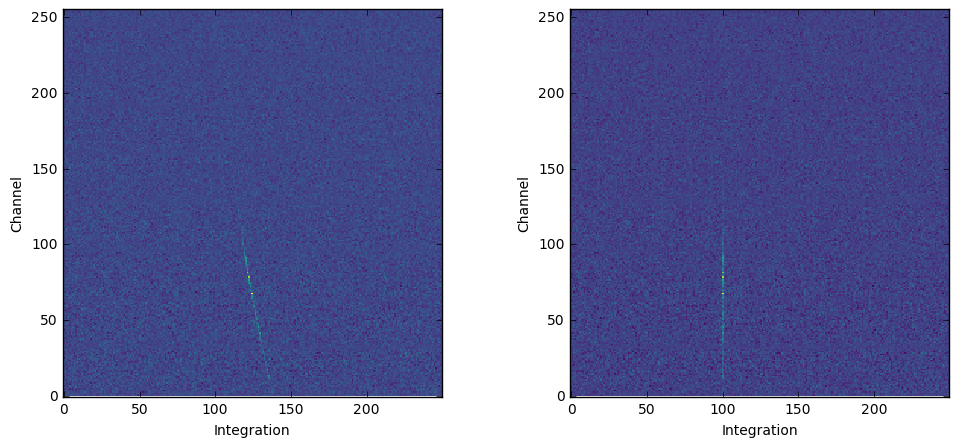

In [10]:
# get spectrogram (frequency-time) data
fig = pl.figure(figsize=(12,5))
pl.subplot(121)
pl.imshow(sgram, interpolation='nearest', origin='lower', cmap='viridis')
pl.xlabel('Integration')
pl.ylabel('Channel')
pl.subplot(122)
pl.imshow(sgramd, interpolation='nearest', origin='lower', cmap='viridis')
pl.xlabel('Integration')
pl.ylabel('Channel')

In [11]:
im = rtpipe.RT.sample_image(st, datadm, u, v, w, i=400)
l,m = rtpipe.RT.calc_lm(st, im)
ra_center, dec_center = st['radec']
ra, dec = rtpipe.reproduce.source_location(ra_center, dec_center, l, m)

print('\nDirty image:')
print('Peak significance: {0:.1f}'.format(im.max()/im.std()))
print('Peak location (J2000): {0}, {1}'.format(ra, dec))

Gridded 0.843 of data. Scaling fft by = 7.2
Pixel sizes (3.9", 3.9"), Field size 1983.3"

Dirty image:
Peak significance: 29.1
Peak location (J2000): 5 31 58.6792300322, 33 8 53.3362355172


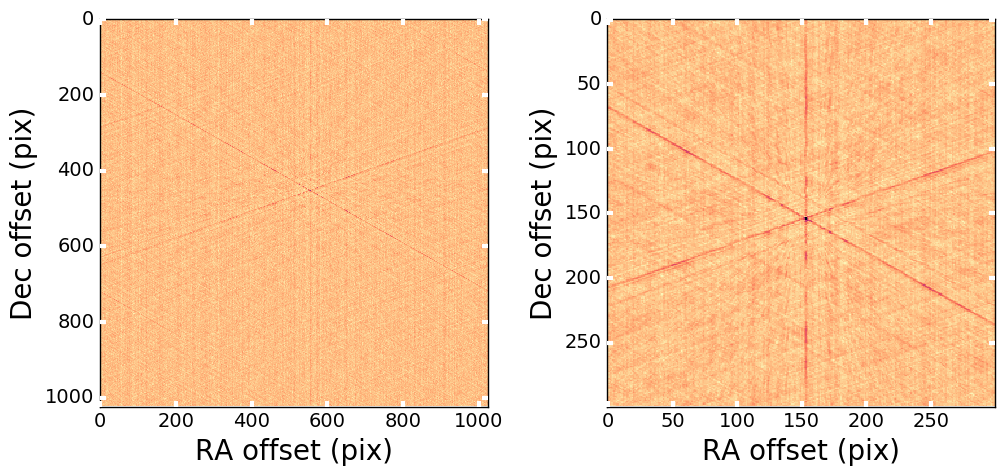

In [12]:
# show me! (full field and zoom)
fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(121)
pl.imshow(im.transpose(), interpolation='nearest', cmap='magma_r')
pl.xlabel('RA offset (pix)', fontsize=20)
pl.ylabel('Dec offset (pix)', fontsize=20)
xt = pl.setp(ax.get_xticklabels(), fontsize=14)
yt = pl.setp(ax.get_yticklabels(), fontsize=14)
ax.xaxis.set_tick_params(width=3, color='w')
ax.yaxis.set_tick_params(width=3, color='w')
ax = fig.add_subplot(122)
pl.imshow(im.transpose()[300:600, 400:700], interpolation='nearest', cmap='magma_r')
pl.xlabel('RA offset (pix)', fontsize=20)
pl.ylabel('Dec offset (pix)', fontsize=20)
xt = pl.setp(ax.get_xticklabels(), fontsize=14)
yt = pl.setp(ax.get_yticklabels(), fontsize=14)
ax.xaxis.set_tick_params(width=3, color='w')
ax.yaxis.set_tick_params(width=3, color='w')

## Plot the spectrum of the burst

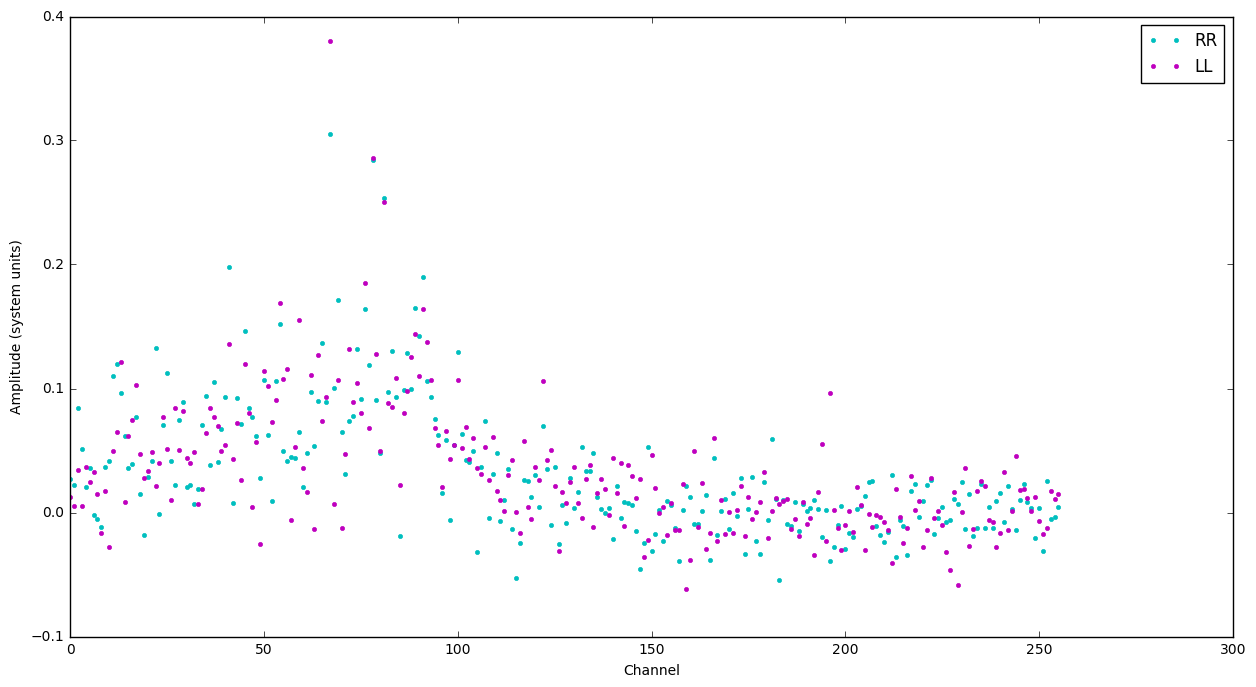

In [15]:
spectra = dataphdm[400].mean(axis=0).real
pl.figure(figsize=(15,8))
pl.plot(spectra[:,0], 'c.', label='RR')
pl.plot(spectra[:,1], 'm.', label='LL')
pl.xlabel('Channel')
pl.ylabel('Amplitude (system units)')
pl.legend()